Note: this dataset was used in place of the Households with Married Couples dataset. We were planning to regress on the number of U.S. households with married couples by year. However, were realized that the dataset was very small (~70 one-dimensional samples), so the result would be easily to predict with maximum possible accuracy by simply using an interpolating polynomial or similar method. Thus we decided on this dataset to run regression on, since it contains 1000 multi-dimensional inputs.

# Preprocessing

In [19]:
import csv
import numpy as np
import matplotlib.pyplot as plt

featureLabels = set([
    "gender",
    "race/ethnicity",
    "parental level of education",
    "lunch",
    "test preparation course"
])
featureMaps = {}
reverseMaps = {}
featureMaps["gender"] = {
    "male"   : [0],
    "female" : [1]
}
featureMaps["race/ethnicity"] = {
    "group A" : [1, 0, 0, 0, 0],
    "group B" : [0, 1, 0, 0, 0],
    "group C" : [0, 0, 1, 0, 0],
    "group D" : [0, 0, 0, 1, 0],
    "group E" : [0, 0, 0, 0, 1]
}
featureMaps["parental level of education"] = {
    "some high school"   : [1, 0, 0, 0, 0, 0],
    "some college"       : [0, 1, 0, 0, 0, 0],
    "bachelor's degree"  : [0, 0, 1, 0, 0, 0],
    "master's degree"    : [0, 0, 0, 1, 0, 0],
    "high school"        : [0, 0, 0, 0, 1, 0],
    "associate's degree" : [0, 0, 0, 0, 0, 1]
}
featureMaps["lunch"] = {
    "standard"     : [0],
    "free/reduced" : [1]
}
featureMaps["test preparation course"] = {
    "none"      : [0],
    "completed" : [1]
}
for key in featureMaps:
    reverseMaps[key] = {str(v): k for k, v in featureMaps[key].iteritems()}

regressionLabels = set([
    "math score",
    "reading score",
    "writing score"
])

def featuresToVector(features, usedFeatures = None):
    """
    features is a dictionary with keys in featureLabels above
    Takes the features and returns a vector (array of 1's/0's corresponding to it)
    """
    if usedFeatures is None:
        usedFeatures = featureLabels
    result = []
    for label in usedFeatures:
        currMap = featureMaps[label]
        currVal = features[label]
        result += currMap[currVal]
    return result

def vectorToFeatures(v, usedFeatures = None):
    """
    Exactly the reverse of the function above.
    """
    if usedFeatures is None:
        usedFeatures = featureLabels
    result = {}
    vTmp = v
    for label in usedFeatures:
        currMap = featureMaps[label]
        currLen = len(currMap.values()[0])
        currVector = vTmp[:currLen]
        vTmp       = vTmp[currLen:]
        currReverseMap = reverseMaps[label]
        result[label] = currReverseMap[str(currVector)]
    return result

def testFeatureConversions():
    """
    Test to check that feature conversions work (featuresToVector and vectorToFeatures)
    """
    with open('students-performance-in-exams/StudentsPerformance.csv', 'rb') as f:
        csvReader = csv.DictReader(f)
        for features in csvReader:
            currVector = featuresToVector(features)
            currFeatures = vectorToFeatures(currVector)
            for label in featureLabels:
                assert features[label] == currFeatures[label]
                
def addOneCol(XOld):
    mOld, nOld = XOld.shape
    X = np.ones( (mOld, nOld + 1) )
    X[:, :-1] = XOld
    return X
                
def calcDataMatrix(usedFeatures = None):
    """
    Returns the X matrix used in linear regression. Adds in the 1 term at the end.
    """
    result = []
    with open('students-performance-in-exams/StudentsPerformance.csv', 'rb') as f:
        csvReader = csv.DictReader(f)
        for features in csvReader:
            currVector = featuresToVector(features, usedFeatures)
            result.append(currVector)
    return np.array(result)

def calcOutputVector(label):
    """
    Returns a y vector on label. label can be any value from regressionLabels
    """
    assert label in regressionLabels
    
    result = []
    with open('students-performance-in-exams/StudentsPerformance.csv', 'rb') as f:
        csvReader = csv.DictReader(f)
        for features in csvReader:
            result.append(int(features[label]))
    return np.array(result, ndmin=2).T


# Uncomment to test feature conversions
# testFeatureConversions()

# X is the data vector from preprocessing
X = calcDataMatrix()
X = preprocessing.scale(X, axis = 1)
print(X.shape)

(1000L, 14L)


## Utility Functions

In [40]:
def makeScatterPlot(title, pointsLists, colors, markers, xlabel = '', ylabel = ''):
    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
     
    for i, pointsList in enumerate(pointsLists):
        currColor = colors[i]
        currMarker = markers[i]
        for point in pointsList:
            x, y = point
            ax.scatter(x, y, c=currColor, marker=currMarker)
        
    # Temporary, add line
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = 0 + 1 * x_vals
    plt.plot(x_vals, y_vals, '--')
    
    # plt.xlim(0, 100)
    # plt.ylim(0, 100)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=2)
    plt.show()

def calcError(y1, y2):
    return abs(y1 - y2)

def KCVsplit(k, X, y):
    """
    Splits the training data (X) into k folds in which one fold is used for testing
    and all the others are used for training. Does this k times. 
    
    :param int k
    :param np.array X
    :param np.array y
    :return: (folds, Xlist, ylist, table) where folds is a list of all 
             the folds, Xlist is a list of np.arrays
             corresponding to the X used for training in each iteration 
             (all the folds except for index i),
             ylist is a list of np.arrays corresponding to the y used for training
             and table is a hash table mapping rows in X to their corresponding
             label y.
    :rtype: tuple of (list of np.array, np.array, np.array, dict)
    """
    Xlist = []
    ylist = []
    table = {}
    
    # Set table up
    for i, row in enumerate(X):
        table[str(row)] = y[i]
    
    # Split X up into folds
    stepSize = int(X.shape[0] / k) + 1
    steps = [min(X.shape[0], stepSize * n) for n in range(1, k)]
    folds = np.split(X, steps)
    foldLabels = np.split(y, steps)
    
    for i, currFold in enumerate(folds):
        # Get XTrain and yTrain with all the other folds except currFold
        otherFolds = [otherFold for j, otherFold in enumerate(folds) if j != i]
        otherFoldLabels = [label for j, label in enumerate(foldLabels) if j != i]
        XTrain = otherFolds[0]
        yTrain = otherFoldLabels[0]
        for j in range(1, len(otherFolds)):
            XTrain = np.append(XTrain, otherFolds[j], axis=0)
            yTrain = np.append(yTrain, otherFoldLabels[j], axis=0)
        Xlist.append(XTrain)
        ylist.append(yTrain)
    
    return (folds, Xlist, ylist, table)

def performValidation(k, X, y, model, plotDiffs = False):
    """
    Performs cross validation
    """
    folds, Xlist, ylist, table = KCVsplit(k, X, y)
    
    # For each fold i, use i as testing, and use all the other
    # i - 1 folds for training. Calculate the errors for each and store
    # them in avgErrors
    predTable = {}
    avgErrors = []
    for i in range(len(Xlist)):
        currFold = folds[i]
        XTrain = Xlist[i]
        yTrain = ylist[i]
        
        # Train the model
        model.fit(XTrain, yTrain)
        
        # Now, evaluate the trained model against the actual labels,
        # keep track of total error!
        totalError = 0
        for row in currFold:
            
            # Get the current predicted value
            currRow = row.reshape(1, -1)
            yPredicted = model.predict(currRow)
            
            totalError += calcError(yPredicted[0], table[str(row)][0])
            predTable[str(row)] = yPredicted
        totalError /= len(currFold)
        avgErrors.append(totalError)
          
    predictions = []
    actuals = []
    plotPoints = []
    for row in X:
        hashVal = str(row)
        predictions.append(predTable[hashVal][0])
        actuals.append(table[hashVal][0])
    plotPoints = [(predictions[i], actuals[i]) for i in range(len(actuals))]

    # Optionally, plot the measured vs predicted values
    if plotDiffs:
        makeScatterPlot("Measured vs Predicted", 
                        [plotPoints], 
                        ['r'], 
                        ['.'],
                        'Predicted',
                        'Actual')
    return avgErrors

def calcRegParameter(modelConstructor, vals, k, X, y, *argv):
    """
    Calculates the best regularization parameter (specified in kwargs) for the 
    model whose constructor is passed in as modelConstructor.
    from the discretized values present in vals.
    Does this by k-fold cross validation on X and y.
    Returns a dictionary mapping each value in argv to the best value for it.
    """
    result = {}
    for key in argv:
        minError = float('inf')
        minVal = float('inf')
        for val in vals:
            folds, XOuterList, yOuterList, table = KCVsplit(k, X, y)
            # Do k-fold CV on the current X and y (which leaves one out)
            for i in range(len(XOuterList)):
                Xcurr = XOuterList[i]
                ycurr = yOuterList[i]
                model = modelConstructor(**{key:val})
                avgErrors = performValidation(k, Xcurr, ycurr, model, plotDiffs = False)
                
                # Update best lambda value if needed
                currError = np.mean(avgErrors)
                if currError < minError:
                    minError = currError
                    minVal = val
        result[key] = minVal
    return result
    

# Least Squares Regression

Performing cross validation for regression on math score.


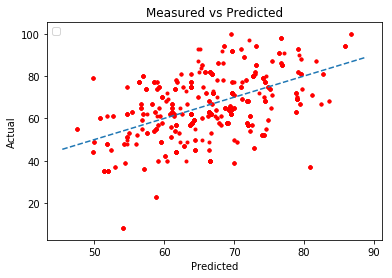

The model coefficients are
[[ -50.8125    ]
 [-126.0625    ]
 [-124.15625   ]
 [-125.125     ]
 [-124.        ]
 [-121.875     ]
 [ -46.625     ]
 [ -53.6875    ]
 [  16.3125    ]
 [  17.28125   ]
 [  19.25      ]
 [  18.53125   ]
 [  16.375     ]
 [  18.375     ]
 [ 102.62249637]]
The average prediction error is 10.6129052172
Performing cross validation for regression on writing score.


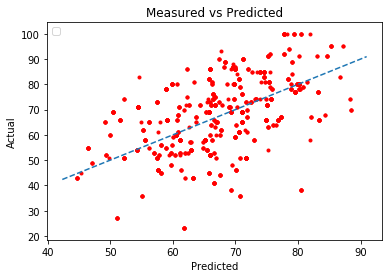

The model coefficients are
[[-15.671875  ]
 [  2.4375    ]
 [  4.015625  ]
 [  2.140625  ]
 [  3.765625  ]
 [  4.453125  ]
 [-15.875     ]
 [-23.6875    ]
 [-43.109375  ]
 [-40.953125  ]
 [-39.21875   ]
 [-39.8125    ]
 [-43.046875  ]
 [-40.703125  ]
 [ 54.89913036]]
The average prediction error is 10.3026833176
Performing cross validation for regression on reading score.


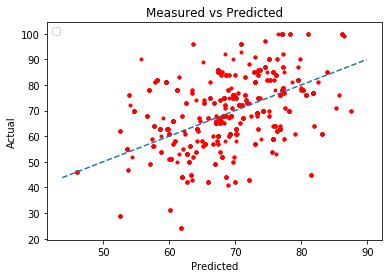

The model coefficients are
[[-16.375     ]
 [-15.4375    ]
 [-15.9375    ]
 [-15.5       ]
 [-15.09375   ]
 [-13.46875   ]
 [-16.875     ]
 [-22.75      ]
 [-26.375     ]
 [-24.90625   ]
 [-23.25      ]
 [-23.75      ]
 [-26.5625    ]
 [-23.875     ]
 [ 65.31104566]]
The average prediction error is 10.1289583774


In [46]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

class LSModel(object):
    def __init__(self):
        self.X = None
        self.y = None
        self.w = None
        self.coef_ = None
        
    def LSTrain(self, X, y):
        # Calculate w = (X^tX)^{-1}X^tY and return it
        w = np.matmul(
                np.linalg.inv(np.matmul(X.T, X)),
                np.matmul(X.T, y)
        )
        return w
    
    def fit(self, X, y):
        self.X = addOneCol(X)
        self.y = y
        self.w = self.LSTrain(self.X, self.y)
        self.coef_ = self.w
        
    def predict(self, x):
        xNew = addOneCol(x).T
        result = [0]
        result = np.matmul(
            self.w.T,
            xNew
        )
        return result

# Set this to true to use scikit learn.
useScikit = False
k = 5
for label in regressionLabels:
    print("Performing cross validation for regression on {}.".format(label))
    y = calcOutputVector(label)
    if useScikit:
        model = LinearRegression()
    else:
        model = LSModel()
    model.fit(X, y)
    avgErrors = performValidation(k, X, y, model, plotDiffs = True)
    finalAvgError = np.mean(avgErrors)
    print("The model coefficients are")
    print(model.coef_)
    print("The average prediction error is {}".format(finalAvgError))


# Ridge Regression

Performing cross validation for regression on math score.
Best lambda value is 0.0


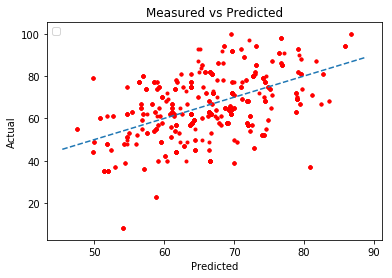

The model coefficients are
[[ -50.8125    ]
 [-126.0625    ]
 [-124.15625   ]
 [-125.125     ]
 [-124.        ]
 [-121.875     ]
 [ -46.625     ]
 [ -53.6875    ]
 [  16.3125    ]
 [  17.28125   ]
 [  19.25      ]
 [  18.53125   ]
 [  16.375     ]
 [  18.375     ]
 [ 102.62249637]]
The average prediction error is 10.6129052172
Performing cross validation for regression on writing score.
Best lambda value is 0.0512820512821


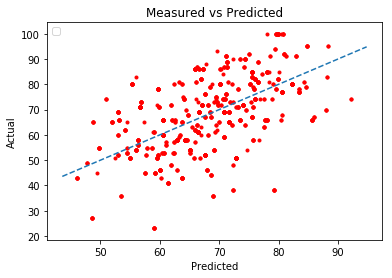

The model coefficients are
[[ 4.06915938]
 [ 3.09953179]
 [ 3.48577284]
 [ 3.99020743]
 [ 5.28761552]
 [ 5.07874691]
 [ 4.70287039]
 [-3.21454115]
 [-6.45987196]
 [-4.84606201]
 [-2.54458625]
 [-2.40659324]
 [-6.19083238]
 [-4.05141726]
 [63.02879661]]
The average prediction error is 10.0867179976
Performing cross validation for regression on reading score.
Best lambda value is 0.0512820512821


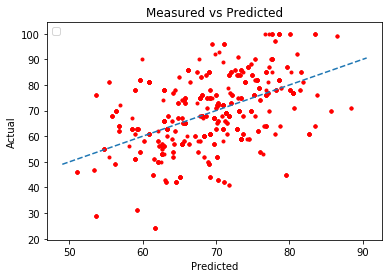

The model coefficients are
[[ 3.11876914]
 [ 2.12416803]
 [ 2.25769099]
 [ 2.6935812 ]
 [ 3.40803141]
 [ 4.07788515]
 [ 3.47198296]
 [-2.8424435 ]
 [-4.4662024 ]
 [-3.58897565]
 [-1.71346783]
 [-1.35093902]
 [-4.46367351]
 [-2.72640697]
 [65.92065307]]
The average prediction error is 9.79989845277


In [47]:
class RRModel(object):
    def __init__(self, L = 1):
        self.X = None
        self.y = None
        self.w = None
        self.L = L
        self.coef_ = None
        
    def RRTrain(self, X, y, L):
        # Calculate Xmult = X^tX + L*I
        Xmult = np.matmul(X.T, X)
        for i in range(Xmult.shape[0]):
            Xmult[i][i] += L
            
        # Calculate w = (X^tX + L*I)^{-1}X^tY and return it
        w = np.matmul(
                np.linalg.inv(Xmult),
                np.matmul(X.T, y)
        )
        return w

    def fit(self, X, y):
        self.X = addOneCol(X)
        self.y = y
        self.w = self.RRTrain(self.X, self.y, self.L)
        self.coef_ = self.w
        
    def predict(self, x):
        xNew = addOneCol(x).T
        result = [0]
        result = np.matmul(
            self.w.T,
            xNew
        )
        return result
    
# Set this to true to use scikit learn.
useScikit = False
vals = np.linspace(0, 2, num = 40)
k = 5
for label in regressionLabels:
    print("Performing cross validation for regression on {}.".format(label))
    y = calcOutputVector(label)
    if useScikit:
        model = LinearRegression()
    else:
        Lbest = calcRegParameter(RRModel, vals, k, X, y, "L")["L"]
        print("Best lambda value is {}".format(Lbest))
        model = RRModel(L = Lbest)
    avgErrors = performValidation(k, X, y, model, plotDiffs = True)
    finalAvgError = np.mean(avgErrors)
    print("The model coefficients are")
    print(model.coef_)
    print("The average prediction error is {}".format(finalAvgError))
    

# Lasso Regression

Performing cross validation for regression on math score.
The best alpha value is 0.01


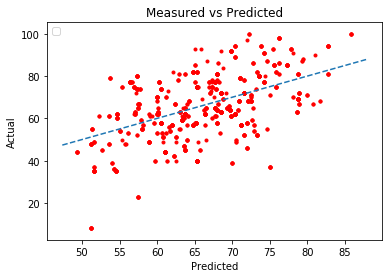

The model coefficients are
[-1.93292555 -0.81336443 -0.17954745  0.          1.09903318  2.96837077
  2.56109677 -4.53316409 -1.26546577 -0.          1.64841344  1.41174292
 -1.09406526  0.67707371]
The average prediction error is 10.5051690158
Performing cross validation for regression on writing score.
The best alpha value is 0.01


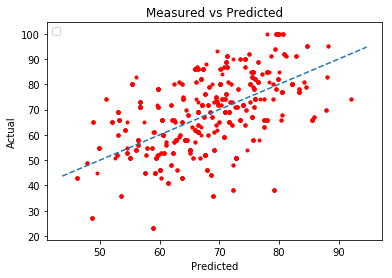

The model coefficients are
[ 4.33638296 -0.87664778 -0.49995615 -0.          1.289565    1.07576316
  4.97503152 -2.92643153 -2.39807517 -0.78347908  1.49394747  1.6250985
 -2.12884221  0.        ]
The average prediction error is 10.0881122157
Performing cross validation for regression on reading score.
The best alpha value is 0.01


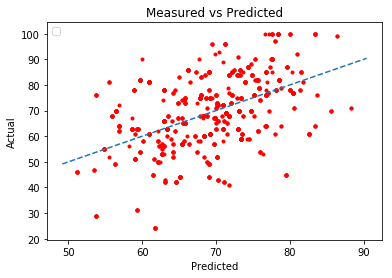

The model coefficients are
[ 3.29132465 -0.55473863 -0.43128347 -0.          0.7059042   1.37120857
  3.64756356 -2.65094302 -1.72865077 -0.85130417  1.00096138  1.35569751
 -1.72654135  0.        ]
The average prediction error is 9.80185587903


In [48]:
from sklearn import linear_model

# Use scikit learn for this since we did not learn a closed-form solution in class.
vals = np.linspace(0.01, 2, num = 40)
k = 5
for label in regressionLabels:
    print("Performing cross validation for regression on {}.".format(label))
    y = calcOutputVector(label)
    alphaBest = calcRegParameter(linear_model.Lasso, vals, k, X, y, "alpha")["alpha"]
    print("The best alpha value is {}".format(alphaBest))
    model = linear_model.Lasso(alpha = alphaBest)
    avgErrors = performValidation(k, X, y, model, plotDiffs = True)
    print("The model coefficients are")
    print(model.coef_)
    finalAvgError = np.mean(avgErrors)
    print("The average prediction error is {}".format(finalAvgError))